In [1]:
import os

def total_files(folder_path):
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return num_files

train_files_healthy = "/kaggle/input/plant-disease-recognition-dataset/Train/Train/Healthy"
train_files_powdery = "/kaggle/input/plant-disease-recognition-dataset/Train/Train/Powdery"
train_files_rust = "/kaggle/input/plant-disease-recognition-dataset/Train/Train/Rust"

test_files_healthy = "/kaggle/input/plant-disease-recognition-dataset/Test/Test/Healthy"
test_files_powdery = "/kaggle/input/plant-disease-recognition-dataset/Test/Test/Powdery"
test_files_rust = "/kaggle/input/plant-disease-recognition-dataset/Test/Test/Rust"

valid_files_healthy = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy"
valid_files_powdery = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Powdery"
valid_files_rust = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust"

print("Number of healthy leaf images in training set", total_files(train_files_healthy))
print("Number of powder leaf images in training set", total_files(train_files_powdery))
print("Number of rusty leaf images in training set", total_files(train_files_rust))

print("========================================================")

print("Number of healthy leaf images in test set", total_files(test_files_healthy))
print("Number of powder leaf images in test set", total_files(test_files_powdery))
print("Number of rusty leaf images in test set", total_files(test_files_rust))

print("========================================================")

print("Number of healthy leaf images in validation set", total_files(valid_files_healthy))
print("Number of powder leaf images in validation set", total_files(valid_files_powdery))
print("Number of rusty leaf images in validation set", total_files(valid_files_rust))

Number of healthy leaf images in training set 458
Number of powder leaf images in training set 430
Number of rusty leaf images in training set 434
Number of healthy leaf images in test set 50
Number of powder leaf images in test set 50
Number of rusty leaf images in test set 50
Number of healthy leaf images in validation set 20
Number of powder leaf images in validation set 20
Number of rusty leaf images in validation set 20


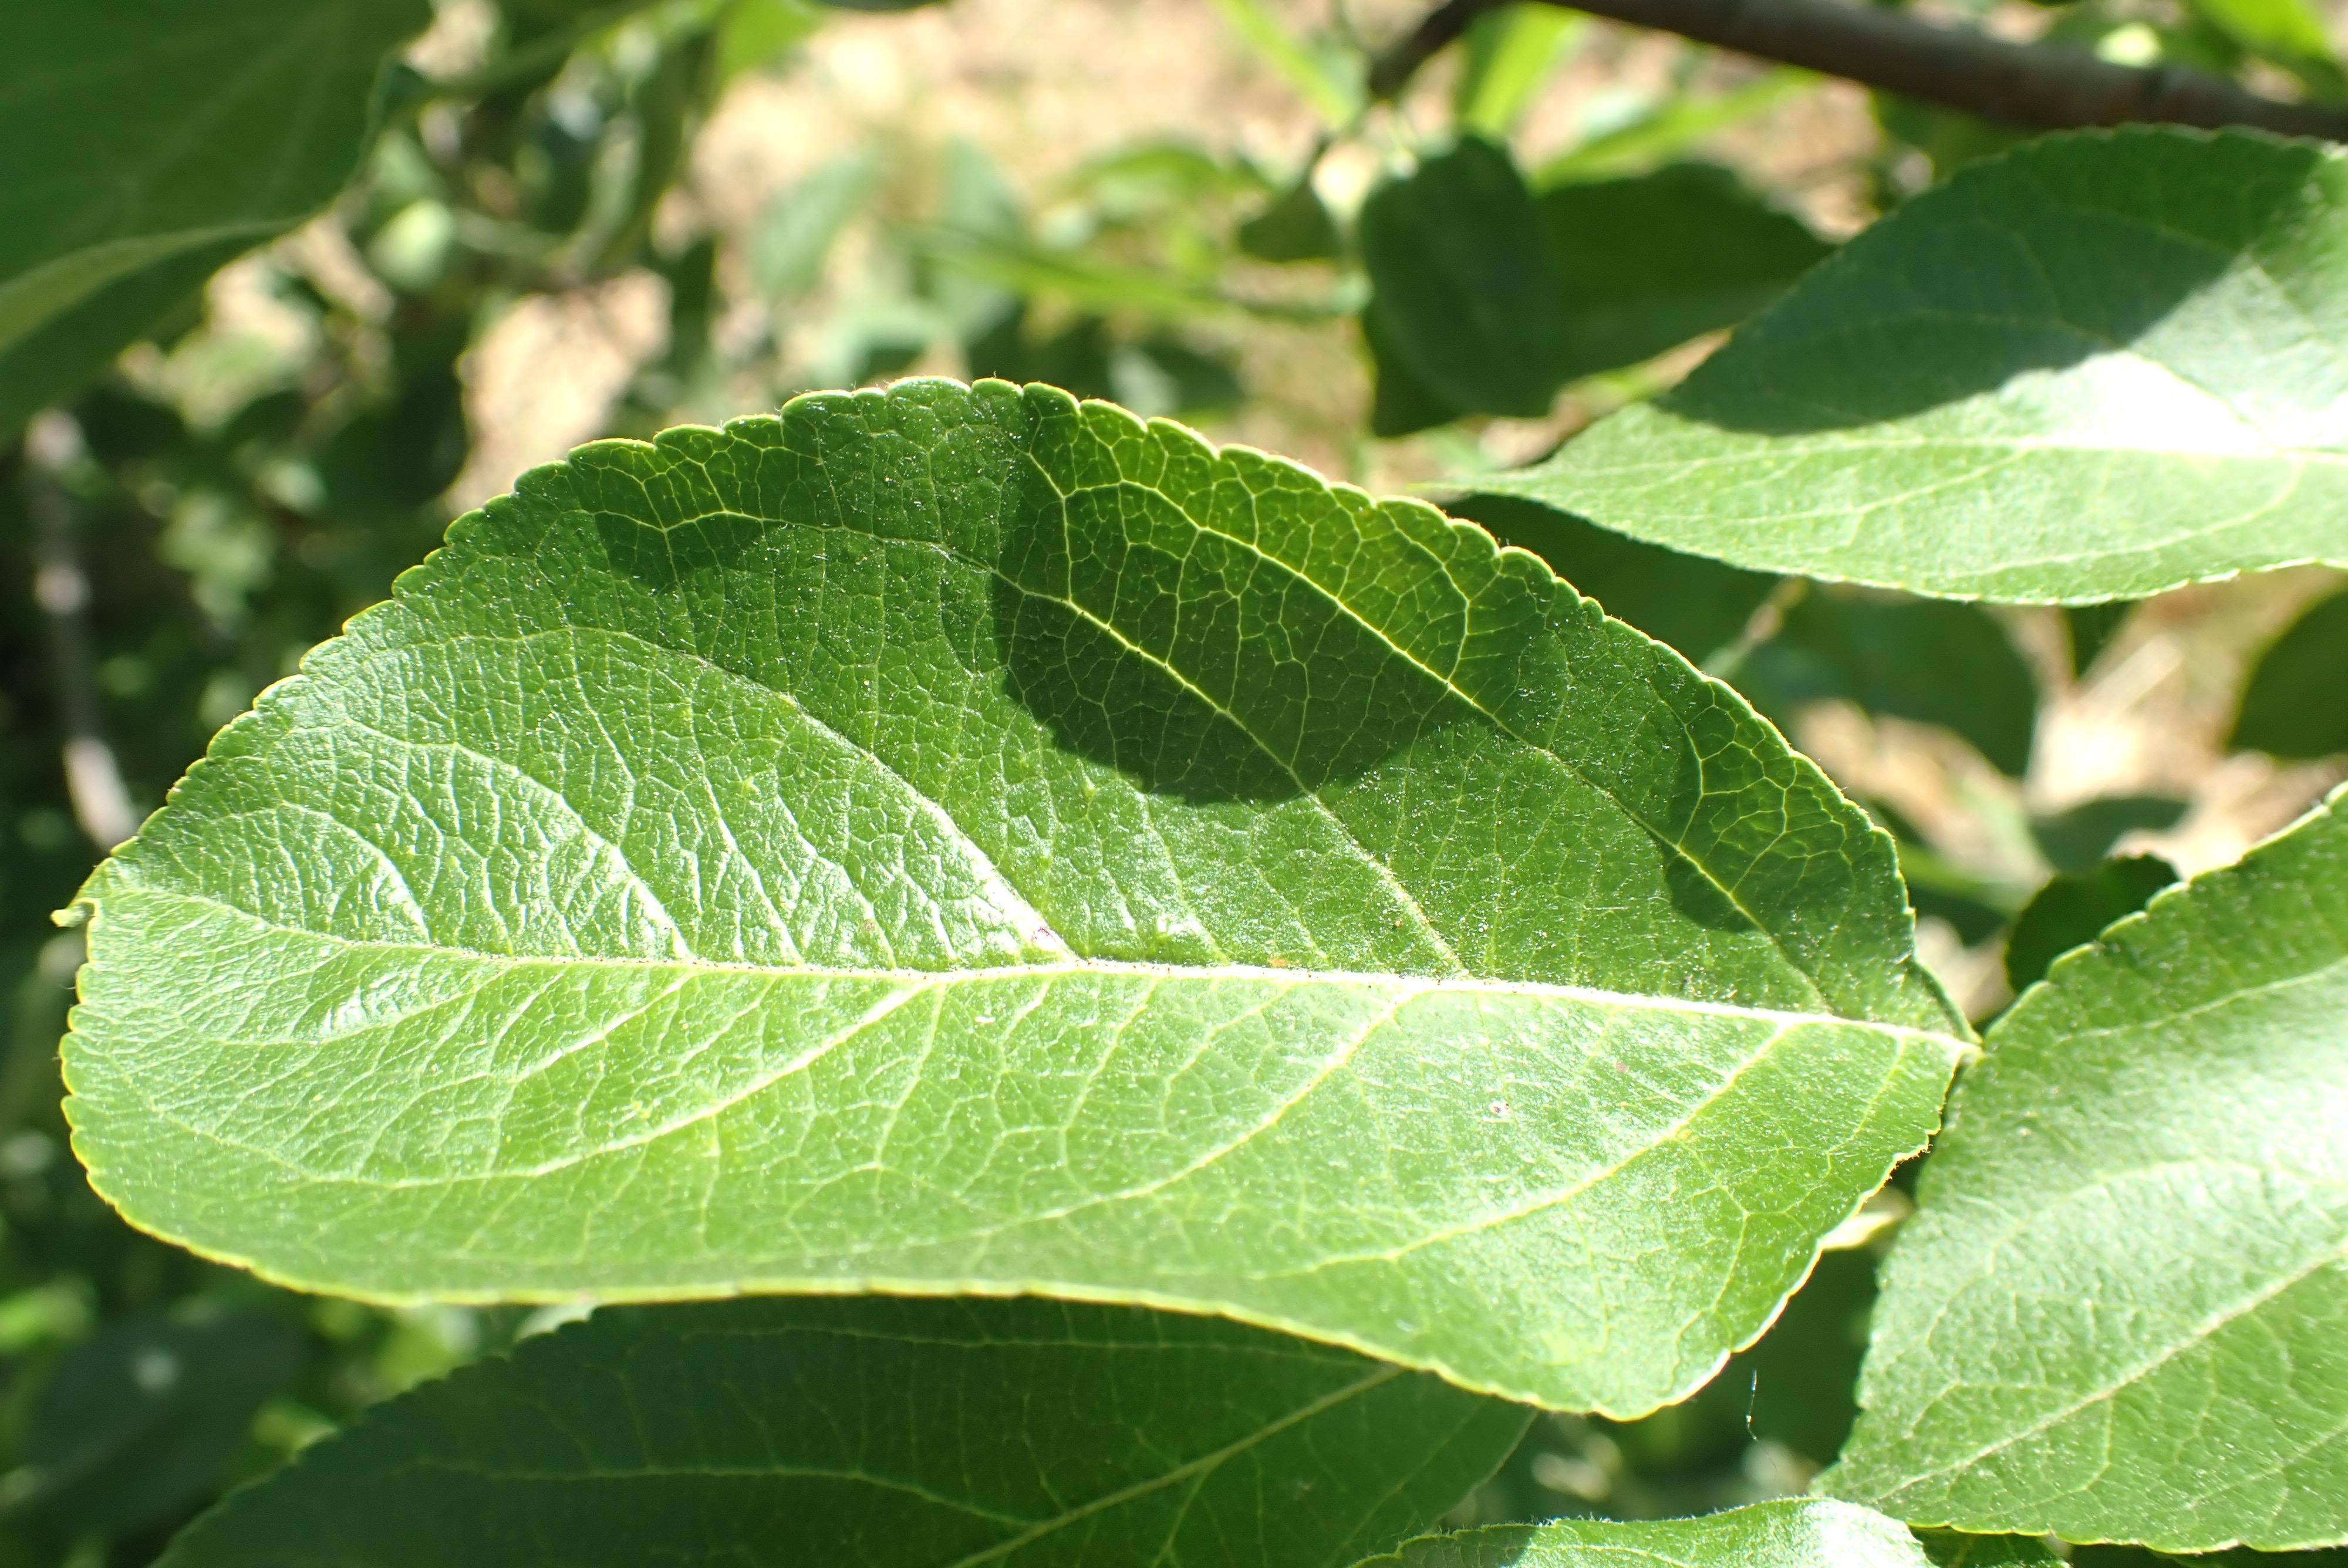

In [2]:
from PIL import Image
import IPython.display as display

image_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Healthy/804e1eda54919fbb.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

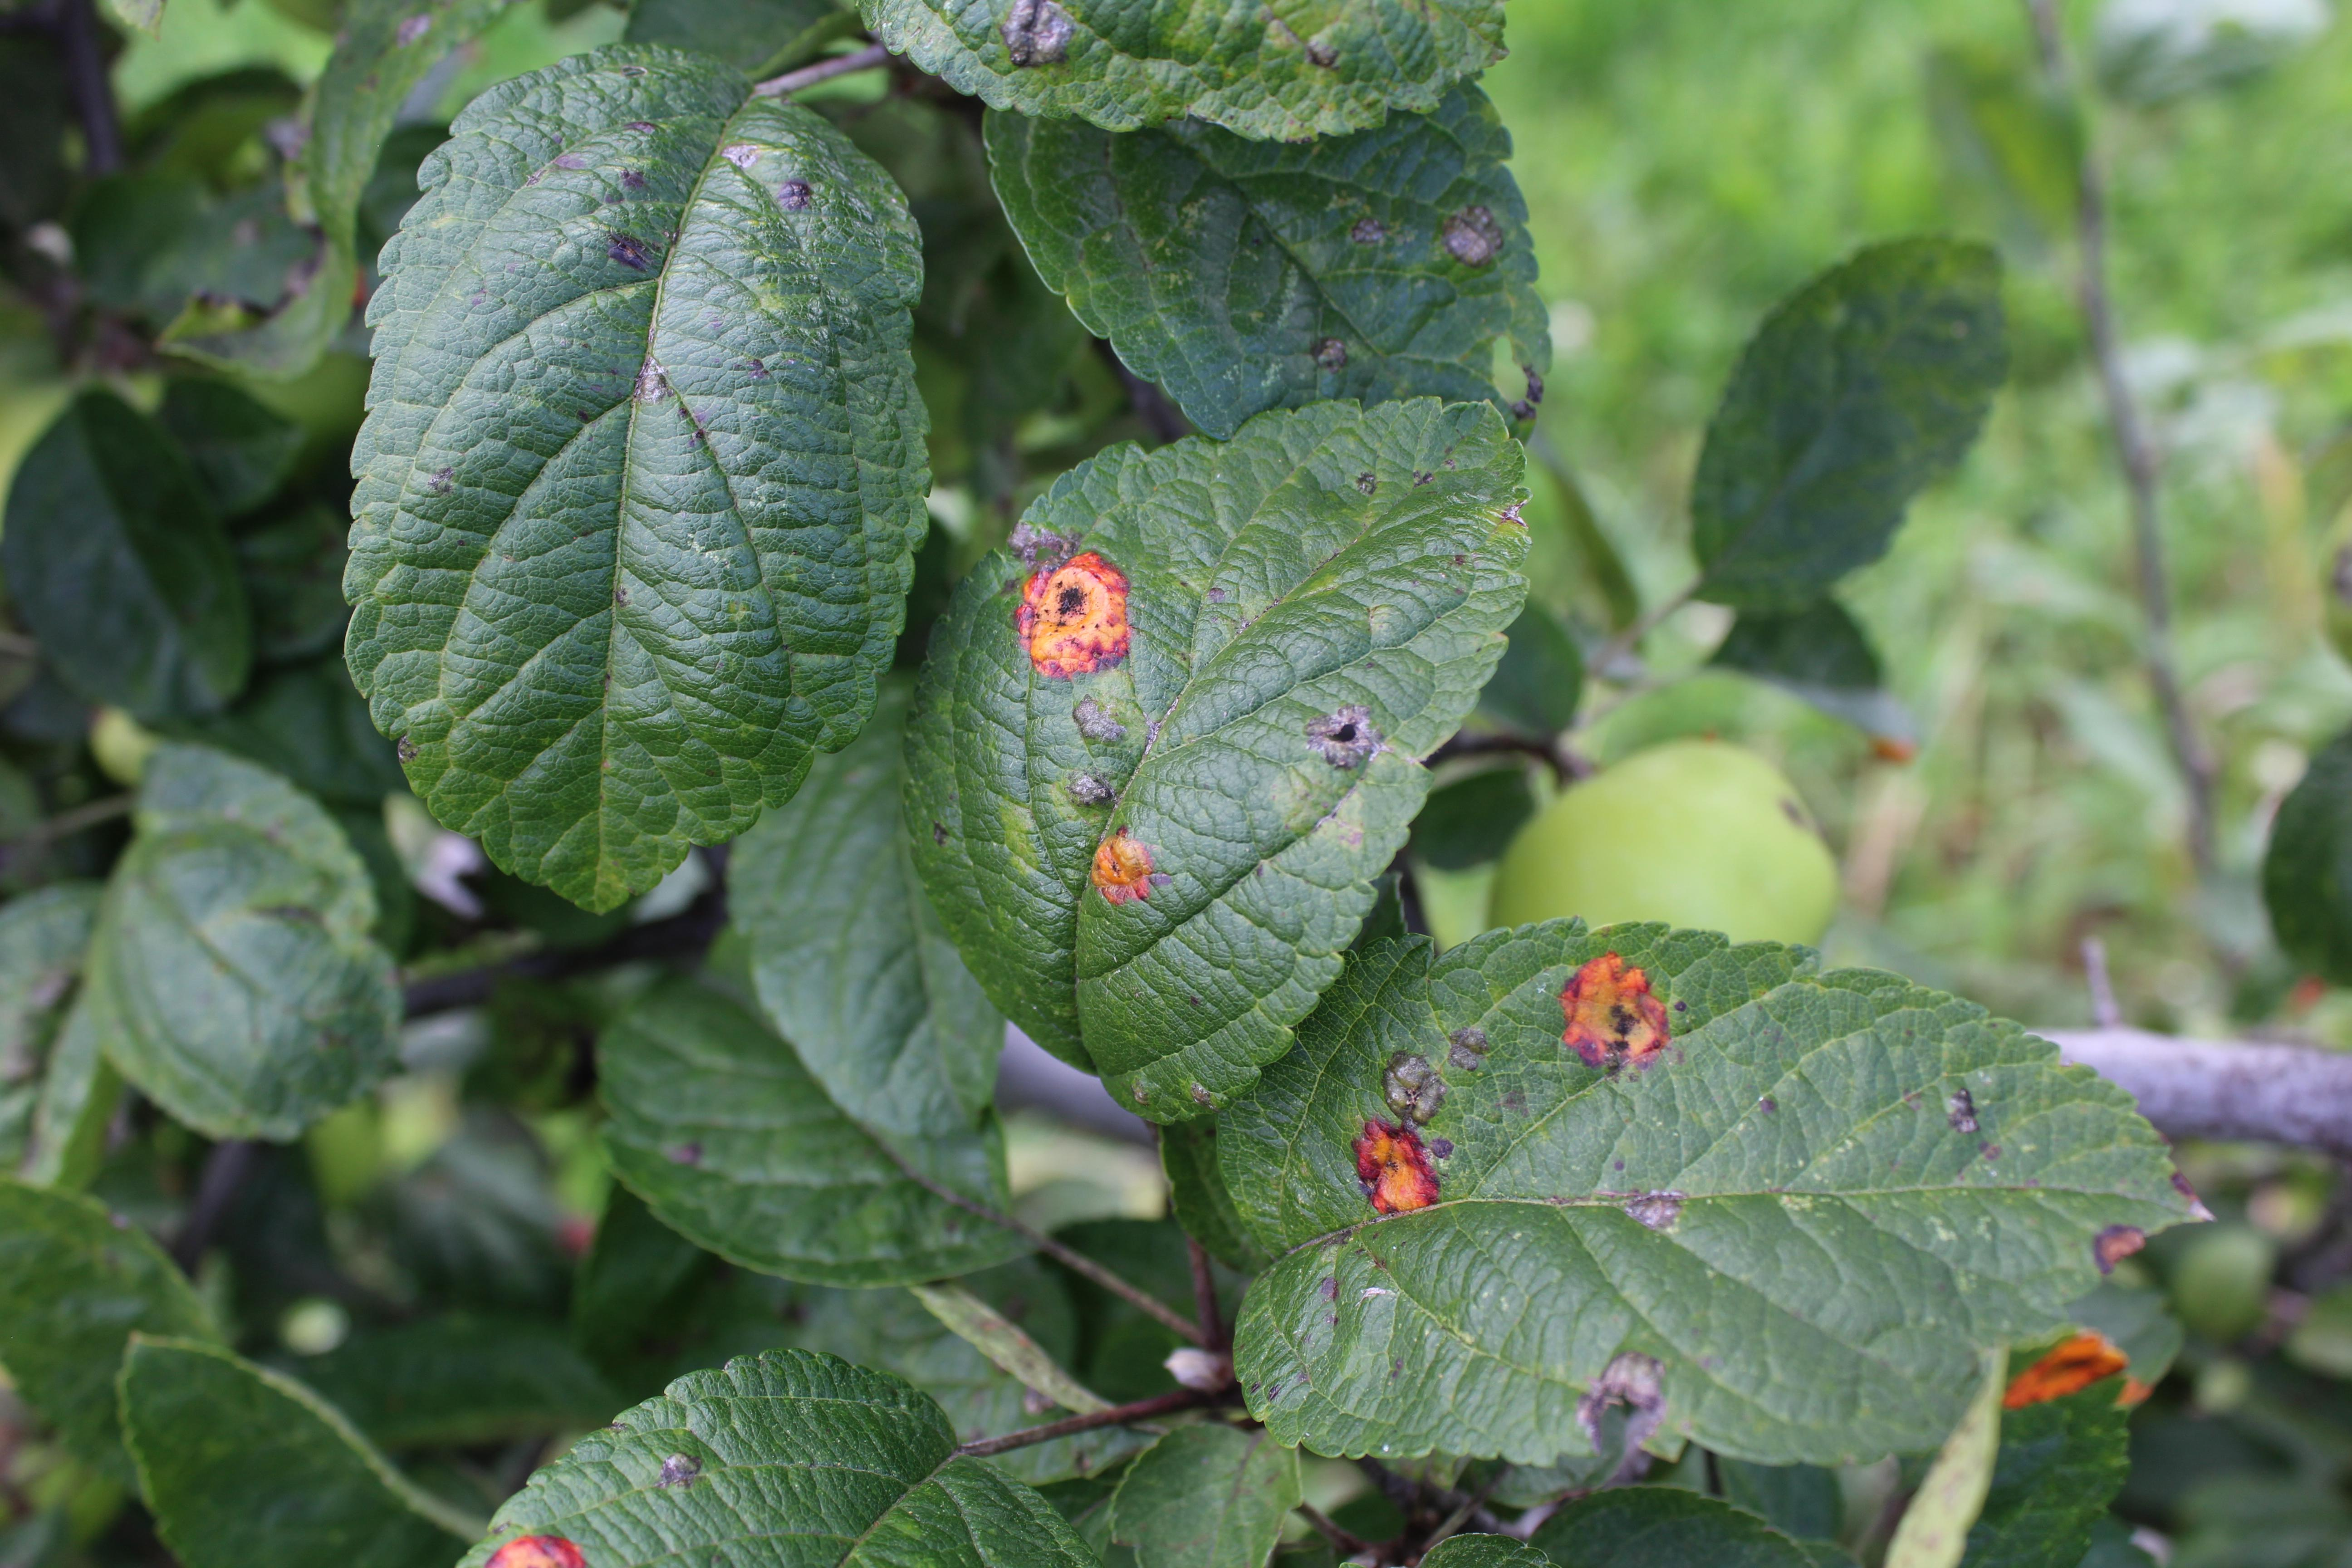

In [3]:
image_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Rust/81a063b69c99ed9e.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

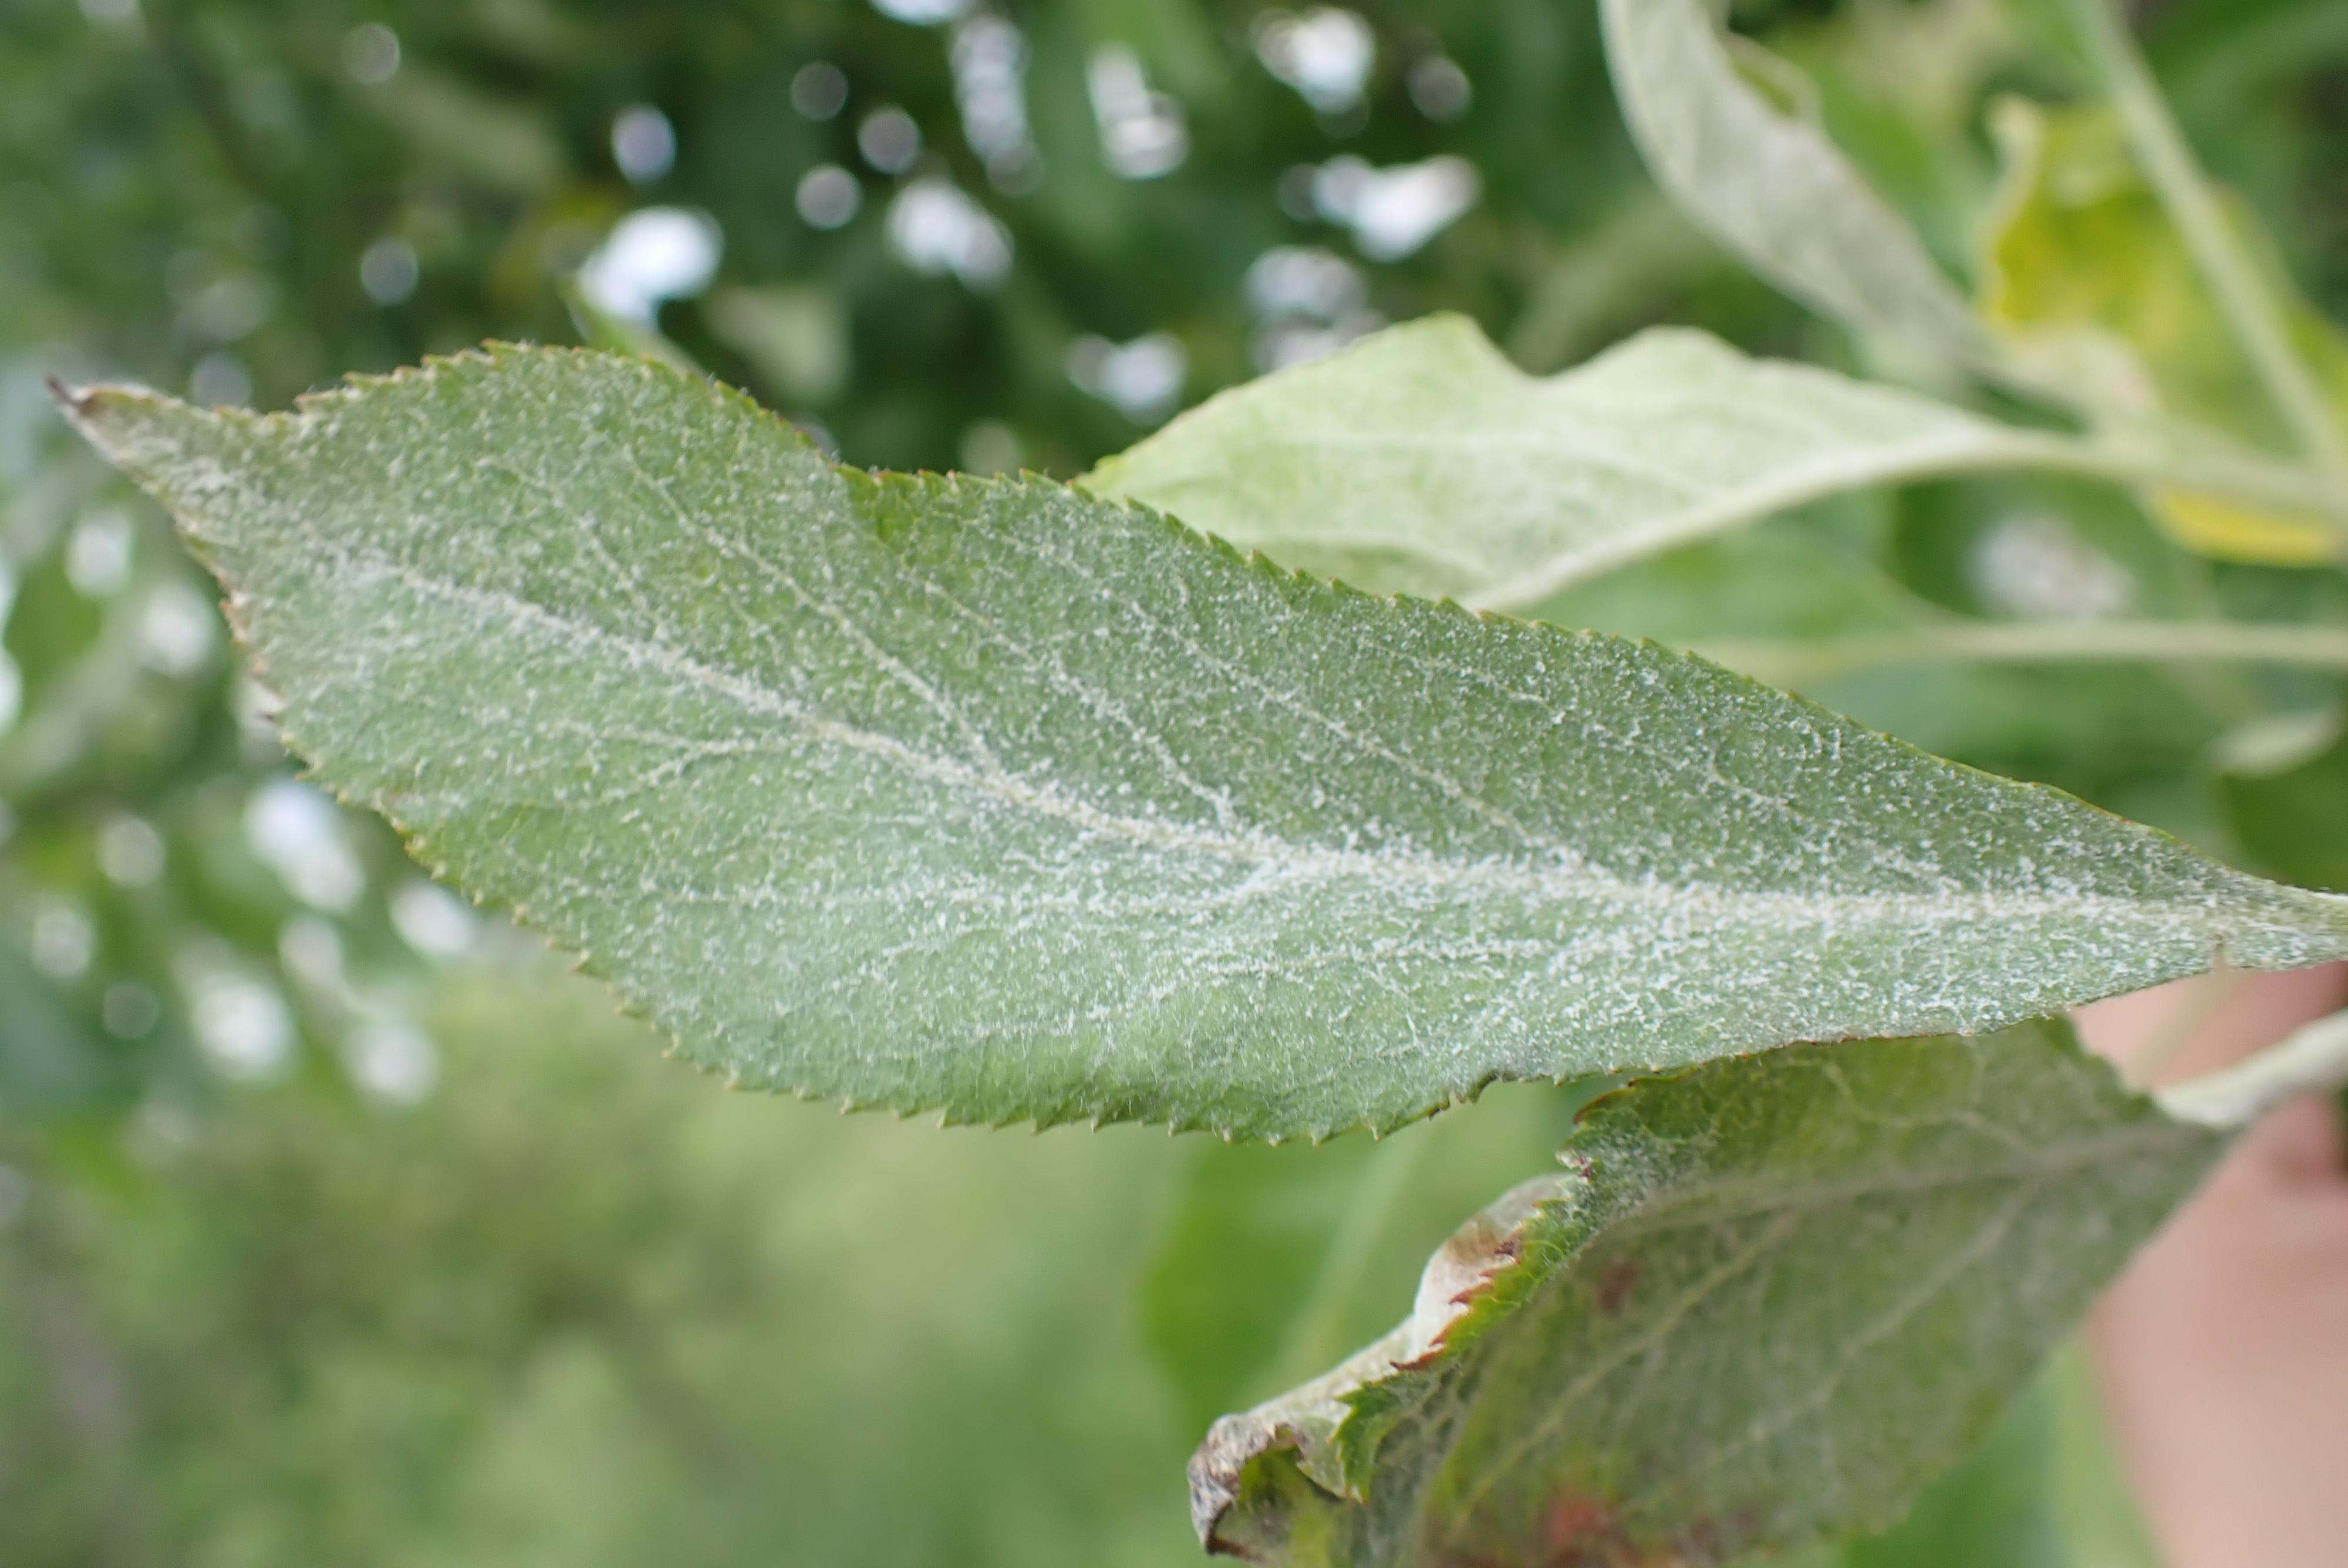

In [4]:
image_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Powdery/81352f0c4c5efa9b.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

2024-09-05 15:26:44.868220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 15:26:44.868353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 15:26:45.018891: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [65]:
train_generator = train_datagen.flow_from_directory('/kaggle/input/plant-disease-recognition-dataset/Train/Train',
                                                    target_size=(224, 224),
                                                    batch_size=128,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('/kaggle/input/plant-disease-recognition-dataset/Validation/Validation',
                                                        target_size=(224, 224),
                                                        batch_size=128,
                                                        class_mode='categorical')

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [67]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50V2(include_top=False,
                  input_shape=(224,224,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

In [70]:
inputs = base_model.input
l1 = Dense(128,activation='relu')(base_model.output)
outputs = Dense(3,activation='softmax')(l1)
model = keras.Model(inputs=inputs,outputs=outputs)

In [72]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Compile the model
from keras.metrics import Precision, Recall, AUC
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [73]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='disease_detection.keras',  # File path where the model will be saved
    monitor='val_accuracy',    # Metric to monitor
    verbose=1,                 # Verbosity mode, 1 will log messages when saving the model
    save_best_only=True,       # Only save the model if `val_accuracy` improves
    mode='max'                 # We want to maximize validation accuracy
)

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

In [74]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint],  # Add `checkpoint` to the list
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/11 ━━━━━━━━━━━━━━━━━━━━ 14:53 89s/step - accuracy: 0.2381 - loss: 1.7686

W0000 00:00:1725551282.079229     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.3396 - loss: 1.4473   

W0000 00:00:1725551285.385859     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5811 - loss: 0.8937
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to disease_detection.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.5931 - loss: 0.8693 - val_accuracy: 0.9500 - val_loss: 0.2385 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9089 - loss: 0.2795
Epoch 2: val_accuracy improved from 0.95000 to 0.98333, saving model to disease_detection.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.9089 - loss: 0.2784 - val_accuracy: 0.9833 - val_loss: 0.1105 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9344 - loss: 0.1831
Epoch 3: val_accuracy did not improve from 0.98333
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9349 - loss: 0.1827 - val_accuracy: 0.9667 - val_loss: 0.1396 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9419 - loss: 0.1619
Epoch 4: val_accura

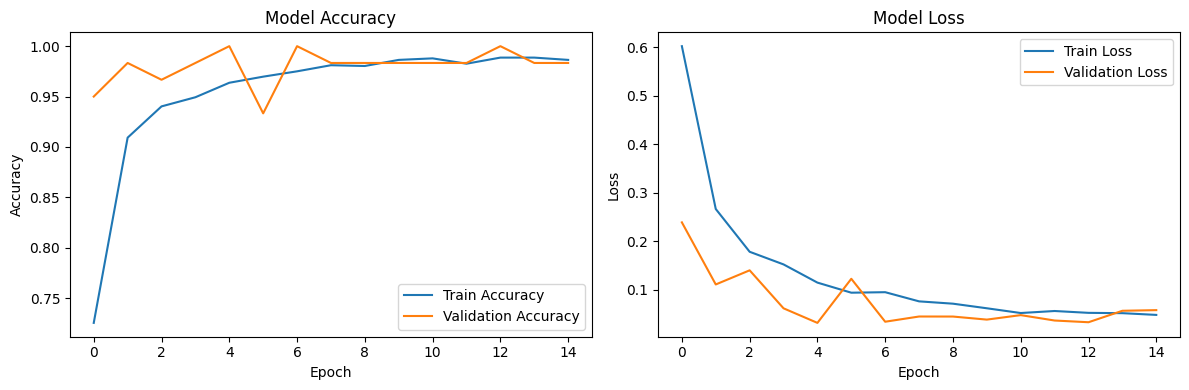

In [75]:
import matplotlib.pyplot as plt  # Correct the import statement

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [76]:
model.save("disease_recognition_efficentnet.h5")